## Load Ice Velocity Data

In [1]:
import numpy as np
import netCDF4

Data about ice sheet motion in Antarctica comes from NSIDC's [Antarctica Ice Velocity Map, Version 2](https://nsidc.org/data/nsidc-0484). The data set exports a 6.8 GB [NetCDF file](http://unidata.github.io/netcdf4-python/netCDF4/index.html).

In [2]:
f = netCDF4.Dataset('data/antarctica_ice_velocity_450m_v2.nc')
print(f)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.6
    Metadata_Conventions: CF-1.6, Unidata Dataset Discovery v1.0, GDS v2.0
    standard_name_vocabulary: CF Standard Name Table (v22, 12 February 2013)
    id: vel_nsidc.CF16.nc
    title: MEaSURES Antarctica Ice Velocity Map 450m spacing
    product_version:  
    summary:  
    keywords:  
    keywords_vocabulary:  
    platform:  
    sensor:  
    date_created: 2017-04-06T17:47:44.00004923343322Z
    institution: Department of Earth System Science, University of California, Irvine
    cdm_data_type: Grid
    geospatial_lat_units: degrees_north
    geospatial_lon_units: degrees_east
    geospatial_lat_min: -90
    geospatial_lat_max: -60
    geospatial_lon_min: -180
    geospatial_lon_max: 180
    spatial_resolution: 450m
    time_coverage_start: 1995-01-01
    time_coverage_end: 2016-12-31
    project: NASA/MEaSUREs
    creator_name: J. Mouginot
    license: No restrictions

## Making a heatmap of ice velocity

We first retrieve the numpy arrays for the variables `VX` and `VY` (components of velocity in m/yr in x/y direction). We then convert the velocity components into magnitude (speed).

In [10]:
velX = f.variables['VX'][:]
velY = f.variables['VY'][:]
speed = (velX ** 2 + velY ** 2) ** 0.5

To decide a color scale, let's first see how speed is distributed.

Note: The data contain missing values (presumably for locations outside of Antarctica), so `VX` and `VY`, and thus `speed`, are [masked arrays](https://numpy.org/devdocs/reference/maskedarray.generic.html). We must first run it through [compressed](https://numpy.org/doc/1.18/reference/generated/numpy.ma.MaskedArray.compressed.html#numpy.ma.MaskedArray.compressed).

In [96]:
speed_values = speed.compressed()

Text(0.5, 1.0, 'Ice speed distribution on a log scale')

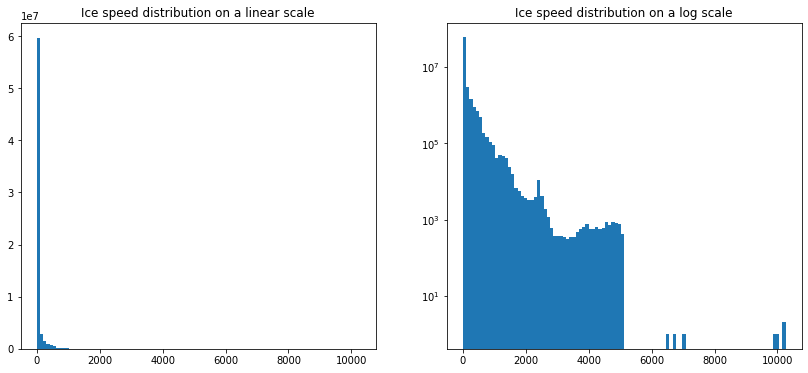

In [118]:
fig, (ax_lin, ax_log) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax_lin.hist(speed_values, bins = 100)
ax_lin.set_title('Ice speed distribution on a linear scale')

ax_log.hist(speed_values, bins = 100)
ax_log.set_yscale('log')
ax_log.set_title('Ice speed distribution on a log scale')

In the log graph there's a weirdly steep cutoff after ~5,000 m/yr but we'll ignore that for now. There are also a few outliers around 7,000 and 10,000. They might be worth annotating/investigating, or maybe they call for a different kind of scale (bins), but we'll do that later.

For now, we'll go with a linear scale maxed at ~2,300 and see what happens. TODO: Find a better way to generate this max value, or just scrap the linear scale.

In [4]:
SPEED_MAX = 2300

The next step is to map each speed to a color.

In [5]:
from matplotlib import cm, colors, pyplot as plt

We'll use a linear scale.

In [6]:
norm = colors.Normalize(vmin=0, vmax=SPEED_MAX)
color_map = cm.ScalarMappable(norm=norm, cmap='viridis')

This color map is too slow, so we'll just do nearest-neighbor index stuff.

In [7]:
NUM_COLORS = 256

In [8]:
cmap = cm.get_cmap('viridis', NUM_COLORS)
cmap_colors = [list(np.around(v[:3] * 255, 2)) + [1] for v in cmap.colors]

Now we map all speeds to their RGBA values. Do scaling first because numpy vectorization speed.

In [21]:
speed_scaled = np.rint(speed / SPEED_MAX * NUM_COLORS).astype(int)

In [11]:
def get_color(s):
    if s is np.ma.masked:
        return [0, 0, 0, 0]
    elif s > 1:
        return cmap_colors[-1]
    return cmap_colors[int(round(s))]

In [ ]:
%%time
speed_rgba = np.array(list(map(lambda array: [get_color(s) for s in array], speed_scaled[5000:10000, 5000:10000])))
print(speed_rgba.shape)

Note the difference in shape: Each speed scalar is now the RGBA tetrad.

In [264]:
speed_rgba.shape, speed.shape

((1000, 1000, 4), (12445, 12445))

## Convert RGBA numpy array to image

In [331]:
from PIL import Image

`Image.fromarray` doesn't work well [with floating points](https://github.com/python-pillow/Pillow/issues/2856), so we cast everything to uint8.

In [ ]:
speed_rgba_uint8 = speed_rgba.astype(np.uint8)

Finally, we create and show the image.

In [ ]:
img = Image.fromarray(speed_rgba_uint8, 'RGBA')
img.save('test.png')
img.show()